# Model 1 - Evaluation 3 (t1 to t4, group 1)

[Model 1](readme.md) is a simple Bayesian regression model to predict word reading at end given age, receptive vocabulary, letter-sound knowledge, phonetic spelling, nonverbal ability, and word reading at start.

The model is defined in [model.py](model.py).

Here, we evaluate the model using observed variables from data set 1 with time 1 as the baseline and time 4 as the outcome, for group 1 (initial intervention) only.


## Preliminaries


In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
import os
import sys
import pymc as pm
import pytensor
import pytensor.tensor as pt
import model as m
from model import ModelSpecification

pd.options.mode.copy_on_write = True

environment = {
    "platform": platform.platform(),
    "platform_version": platform.version(),
    "architecture": platform.architecture(),
    "processor": platform.processor(),
    "cpu_count": os.cpu_count(),
    "python": sys.version,
    "pymc": pm.__version__,
    "pytensor": pytensor.__version__,
    "numpy": np.__version__,
    "arviz": az.__version__,
}

print("Environment:")
for key, value in environment.items():
    print(f"  {key}: {value}")

Environment:
  platform: macOS-15.6.1-arm64-arm-64bit-Mach-O
  platform_version: Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:55 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6031
  architecture: ('64bit', 'Mach-O')
  processor: arm
  cpu_count: 16
  python: 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]
  pymc: 5.25.1
  pytensor: 2.31.7
  numpy: 2.3.3
  arviz: 0.22.0


### Load data


In [4]:
df = pd.read_csv(
    "../../../../../data/reading-language-intervention-trial/rli-trial-data.csv"
).convert_dtypes()
df = df[df["included"] == 1]
df = df[df["group"] == 1] # group 1 only (initial intervention)

## Evaluate model


### Build model


In [5]:
spec = ModelSpecification(
    age=df["age_t1"].to_numpy(),
    nv_start=df["block_design_raw_t1"].to_numpy(),
    rv_start=df["recep_vocab_t1"].to_numpy(),
    ls_start=df["letter_sound_t1"].to_numpy(),
    sp_start=df["phon_spell_t1"].to_numpy(),
    wr_start=df["word_reading_t1"].to_numpy(),
    wr_end=df["word_reading_t4"].to_numpy(),
)

model_def = m.build_model(spec)

model = model_def.model

### Model graph


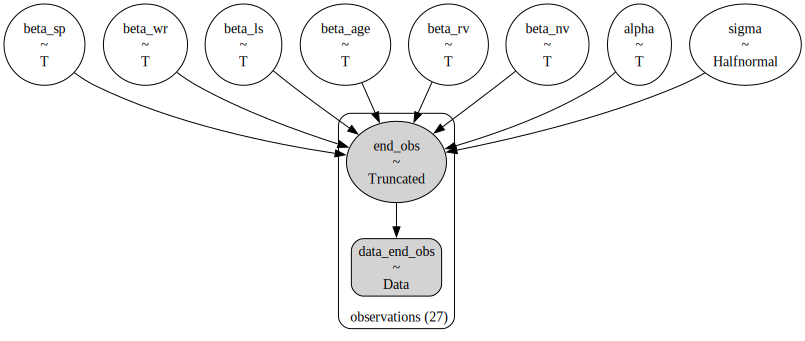

In [6]:
pm.model_to_graphviz(model)

### Run simulation


In [7]:
CHAINS = 4
CORES = CHAINS
RANDOM_SEED = 202509
rng = np.random.default_rng(RANDOM_SEED)

with model:
    trace = pm.sample(
        draws=4000,
        tune=4000,
        chains=CHAINS,
        cores=CORES,
        target_accept=0.95,
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_nv, beta_rv, beta_ls, beta_sp, beta_wr, sigma]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 12 seconds.


In [8]:
with model:
    pm.compute_log_likelihood(trace)

    # Generate replicated outcomes end_obs from the posterior
    post_pred = pm.sample_posterior_predictive(
        trace.posterior,
        var_names=["end_obs"],
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )

    # Prior predictive for prior checks
    prior_pred = pm.sample_prior_predictive(
        samples=1000,
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )

    trace.extend(post_pred)

Output()

Sampling: [end_obs]


Output()

Sampling: [alpha, beta_age, beta_ls, beta_nv, beta_rv, beta_sp, beta_wr, end_obs, sigma]


## Analysis


### Summary statistics

#### Summary statistics (HDI probability = 95%)


In [9]:
summary = az.summary(
    trace,
    var_names=[
        "alpha",
        "beta_age",
        "beta_nv",
        "beta_rv",
        "beta_ls",
        "beta_sp",
        "beta_wr",
        "sigma",
    ],
    round_to=3,
    hdi_prob=0.95,
)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,12.194,4.552,3.079,18.999,0.096,0.141,2794.151,3387.131,1.000
beta_age,-0.346,0.241,-0.831,0.081,0.003,0.008,7180.956,4610.226,1.000
beta_nv,-0.569,0.868,-2.439,1.022,0.015,0.016,3960.069,2635.451,1.000
beta_rv,0.769,0.423,0.083,1.632,0.007,0.009,4770.330,4811.764,1.001
beta_ls,0.820,0.471,-0.063,1.763,0.006,0.007,5932.003,6725.768,1.000
beta_sp,-0.216,0.502,-0.998,1.090,0.013,0.029,2535.247,1043.940,1.001
beta_wr,1.239,0.479,0.410,2.098,0.009,0.025,3975.396,2882.511,1.001
sigma,8.040,2.457,4.107,12.920,0.049,0.052,2935.984,3949.380,1.001


#### Summary statistics (HDI probability = 90%)


In [10]:
summary_90 = az.summary(
    trace,
    var_names=[
        "alpha",
        "beta_age",
        "beta_nv",
        "beta_rv",
        "beta_ls",
        "beta_sp",
        "beta_wr",
        "sigma",
    ],
    round_to=3,
    hdi_prob=0.9,
)
summary_90

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,12.194,4.552,5.715,18.328,0.096,0.141,2794.151,3387.131,1.000
beta_age,-0.346,0.241,-0.683,0.006,0.003,0.008,7180.956,4610.226,1.000
beta_nv,-0.569,0.868,-2.020,0.750,0.015,0.016,3960.069,2635.451,1.000
beta_rv,0.769,0.423,0.186,1.442,0.007,0.009,4770.330,4811.764,1.001
beta_ls,0.820,0.471,0.073,1.559,0.006,0.007,5932.003,6725.768,1.000
beta_sp,-0.216,0.502,-0.797,0.422,0.013,0.029,2535.247,1043.940,1.001
beta_wr,1.239,0.479,0.562,1.907,0.009,0.025,3975.396,2882.511,1.001
sigma,8.040,2.457,4.519,11.626,0.049,0.052,2935.984,3949.380,1.001


### Trace plots


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_age'}>],
       [<Axes: title={'center': 'beta_nv'}>,
        <Axes: title={'center': 'beta_nv'}>],
       [<Axes: title={'center': 'beta_rv'}>,
        <Axes: title={'center': 'beta_rv'}>],
       [<Axes: title={'center': 'beta_ls'}>,
        <Axes: title={'center': 'beta_ls'}>],
       [<Axes: title={'center': 'beta_sp'}>,
        <Axes: title={'center': 'beta_sp'}>],
       [<Axes: title={'center': 'beta_wr'}>,
        <Axes: title={'center': 'beta_wr'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

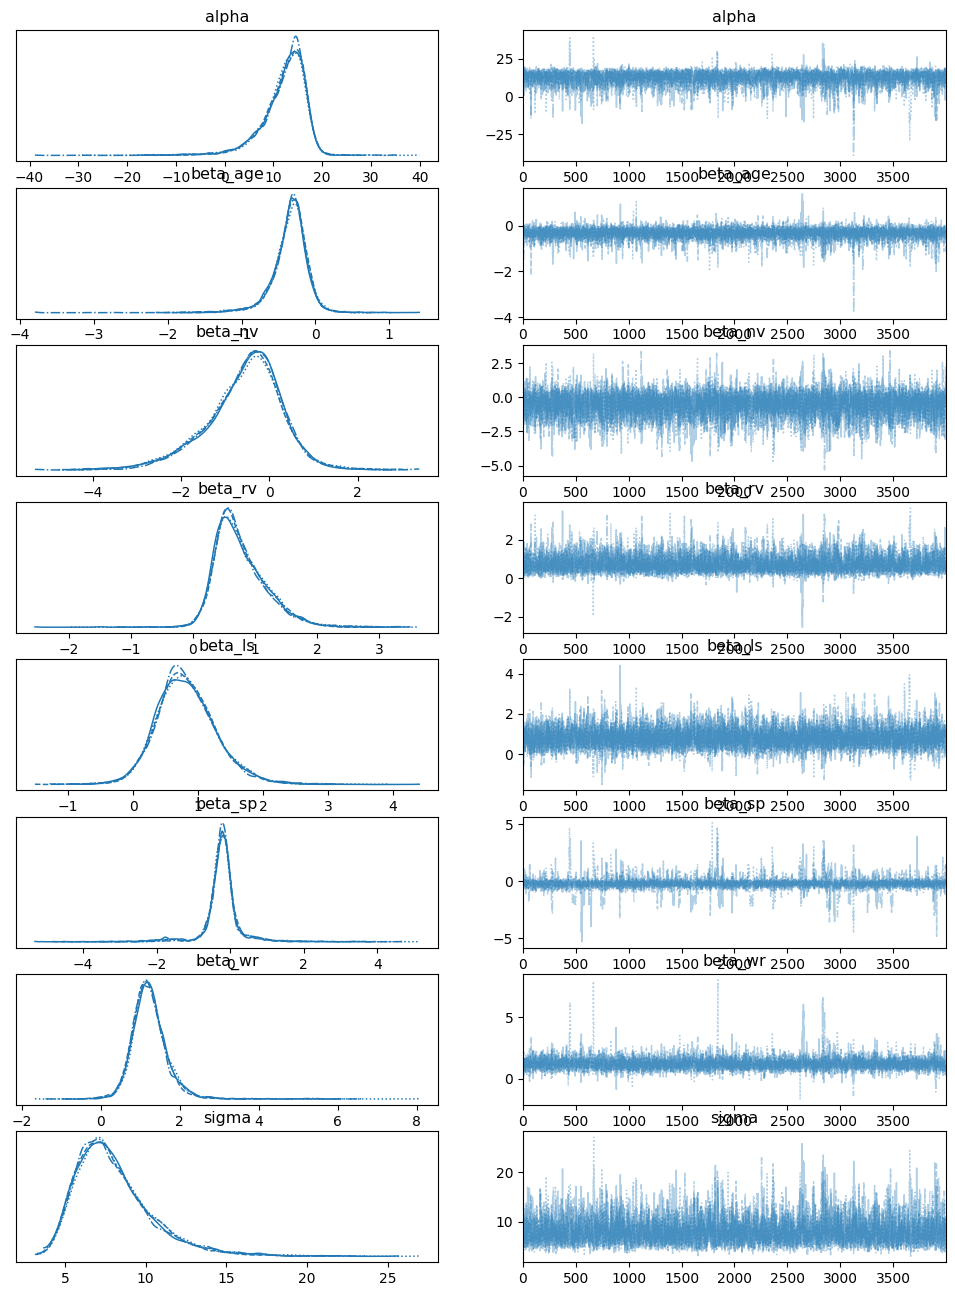

In [11]:
az.plot_trace(
    trace,
    var_names=[
        "alpha",
        "beta_age",
        "beta_nv",
        "beta_rv",
        "beta_ls",
        "beta_sp",
        "beta_wr",
        "sigma",
    ],
)

### Autocorrelation plots


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_nv'}>,
        <Axes: title={'center': 'beta_rv'}>],
       [<Axes: title={'center': 'beta_ls'}>,
        <Axes: title={'center': 'beta_sp'}>,
        <Axes: title={'center': 'beta_wr'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

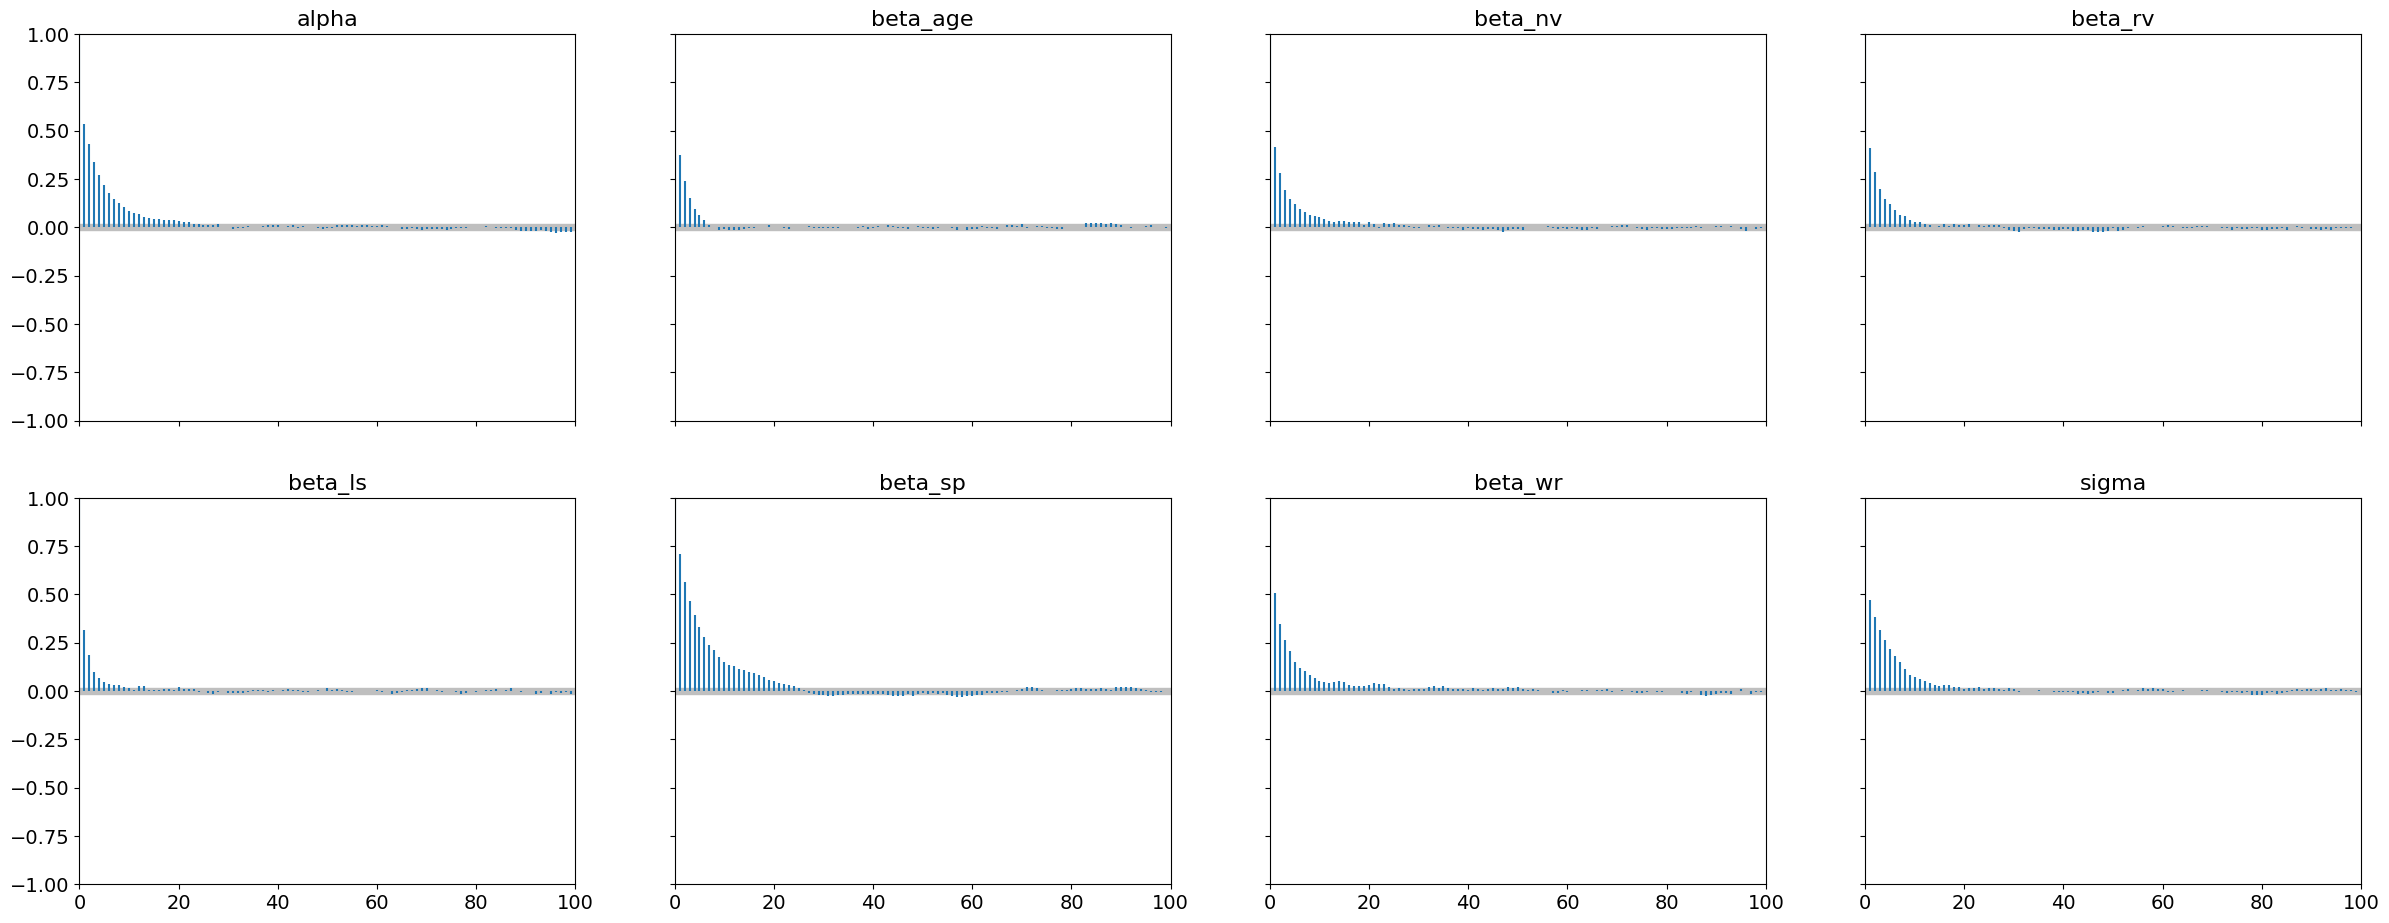

In [12]:
az.plot_autocorr(trace, combined=True)

## Forest plot

The forest plot presents summaries of the posterior for each parameter. Points are the posterior means. The bars show the highest density interval. Thicker bars, if shown, are 50% HDI.


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

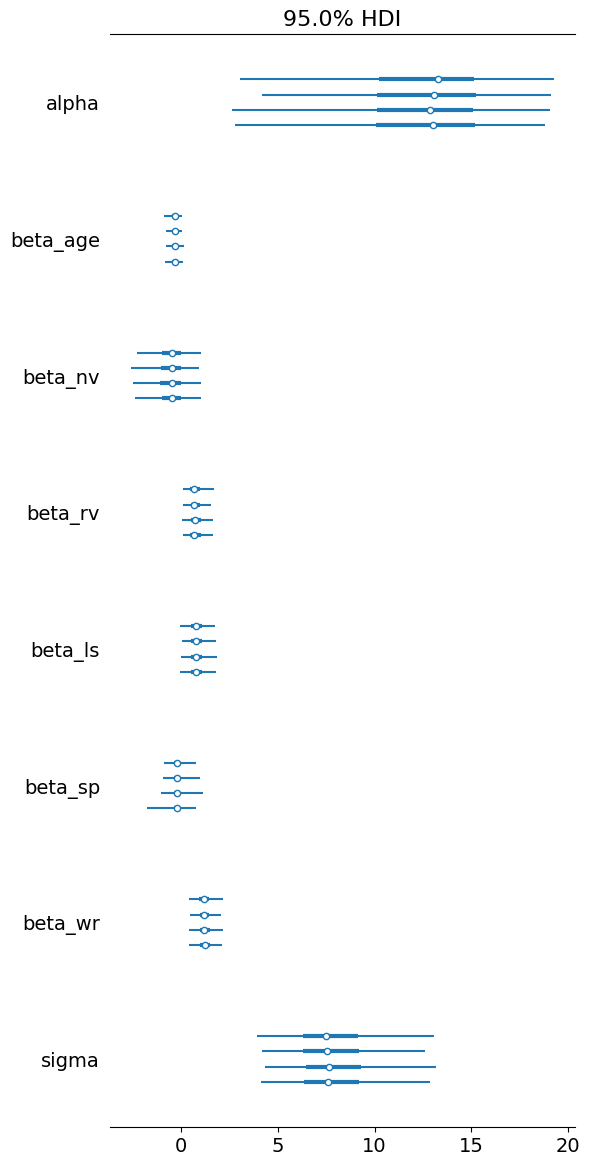

In [13]:
az.plot_forest(
    trace,
    var_names=[
        "alpha",
        "beta_age",
        "beta_nv",
        "beta_rv",
        "beta_ls",
        "beta_sp",
        "beta_wr",
        "sigma",
    ],
    hdi_prob=0.95,
)

### Rank plots

Rank plots should be roughly flat; strong patterns hint at divergences or funnel geometry.


array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta_age'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta_nv'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta_rv'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta_ls'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta_sp'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta_wr'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

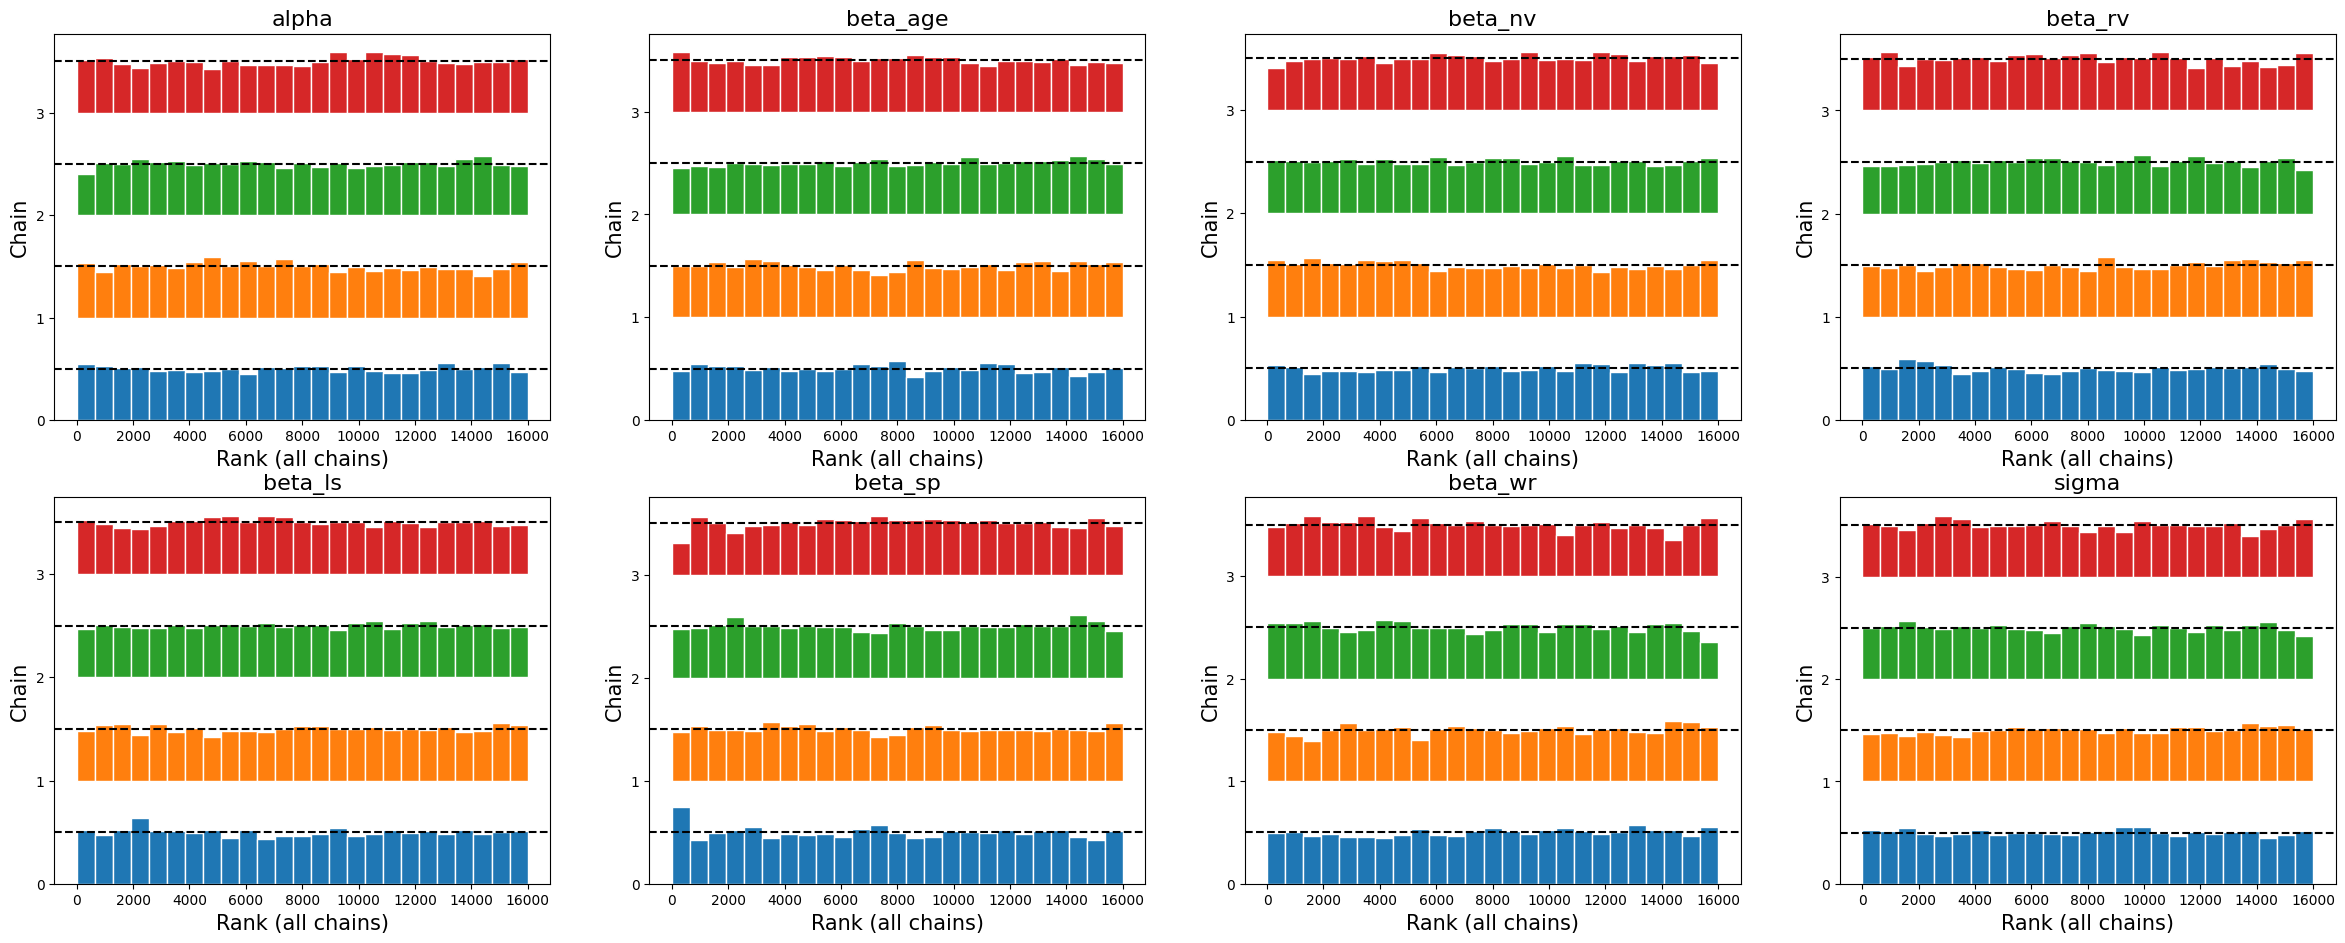

In [14]:
az.plot_rank(
    trace,
    var_names=[
        "alpha",
        "beta_age",
        "beta_nv",
        "beta_rv",
        "beta_ls",
        "beta_sp",
        "beta_wr",
        "sigma",
    ],
)

### Energy plot

Energy plot / E-BFMI: very low values suggest poor exploration; reparameterise or standardise.


<Axes: >

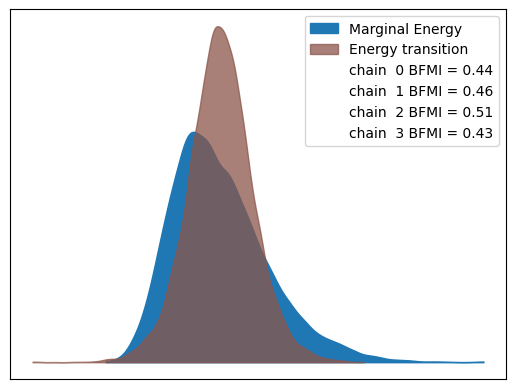

In [15]:
az.plot_energy(trace)

### Posterior predictive checks


<Axes: xlabel='end_obs'>

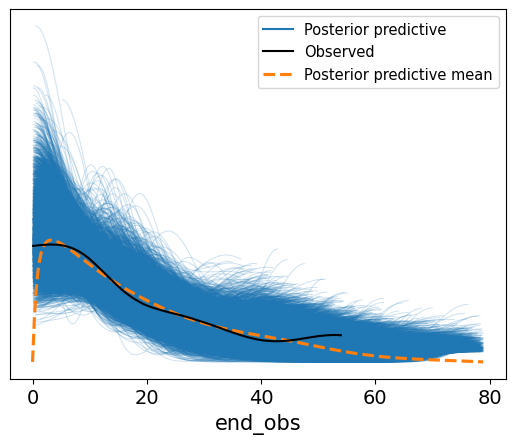

In [16]:
az.plot_ppc(post_pred, data_pairs={"end_obs": "end_obs"})

### Prior predictive checks


<Axes: xlabel='end_obs'>

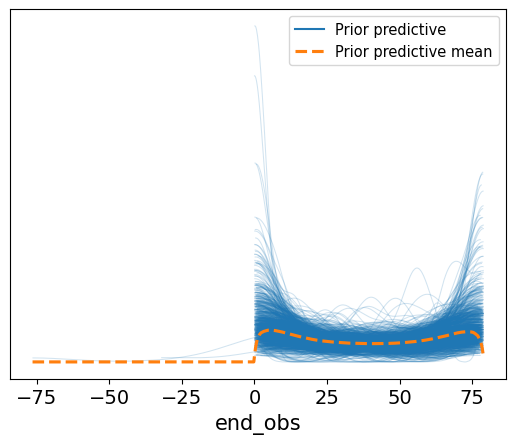

In [17]:
az.plot_ppc(prior_pred, group="prior", data_pairs={"end_obs": "end_obs"})